In [ ]:
# Check if GPU is available
import torch
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Install required packages
!pip install transformers pandas numpy scikit-learn matplotlib seaborn torch
!pip install flask flask-cors

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Connect to Google Drive for saving models
from google.colab import drive
drive.mount('/content/drive')

# Create a directory for our project
PROJECT_DIR = '/content/drive/MyDrive/mbti_classifier1'
!mkdir -p {PROJECT_DIR}

GPU available: True
GPU device: Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split

# Let's assume the dataset is uploaded to Colab
# If you need to upload it, use this code:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload the CSV file

# Load the dataset
df = pd.read_csv('mbti_1.csv')  # Replace with your filename
print(f"Dataset shape: {df.shape}")
print(df.head())

# Check distribution of MBTI types
print(df['type'].value_counts())

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove emojis and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing to the text column
df['processed_text'] = df['text'].apply(preprocess_text)

# Split each user's posts into individual posts
# Let's assume posts are separated by "|||" in the dataset
def split_posts(text, max_posts=3):
    posts = text.split('|||')
    # Limit to max_posts
    limited_posts = posts[:max_posts]
    # Join back for BERT processing
    return ' [SEP] '.join(limited_posts)

df['limited_posts'] = df['processed_text'].apply(lambda x: split_posts(x, max_posts=3))

# Print an example of the processed data
print("\nExample of processed data:")
print(df[['type', 'limited_posts']].iloc[0])

# Split into training, validation, and test sets (60-20-20 split)
X = df['limited_posts'].values
y = df['type'].values

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 60% train, 20% validation (from the remaining 80%)
# To get a 60-20 split from the 80% remaining data, we need test_size=0.25 (20/80 = 0.25)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"\nTraining samples: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]:.1%} of total)")
print(f"Validation samples: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]:.1%} of total)")
print(f"Test samples: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]:.1%} of total)")

Saving mbti_1.csv to mbti_1.csv
Dataset shape: (8675, 2)
   type                                               text
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

Example of processed data:
type                                                          INFJ
limited_posts    and intj moments sportscenter not top ten play...
Name: 0, dtype: object

Training samples: 5205 (60.0% of total)
Validation samples: 1735 (20.0% of total)
Test samples: 1735 (20.0% of total)


Class weights to handle imbalance:
ENFJ: 2.85
ENFP: 0.80
ENTJ: 2.34
ENTP: 0.79
ESFJ: 13.01
ESFP: 11.22
ESTJ: 14.14
ESTP: 6.14
INFJ: 0.37
INFP: 0.30
INTJ: 0.50
INTP: 0.42
ISFJ: 3.25
ISFP: 2.00
ISTJ: 2.64
ISTP: 1.61


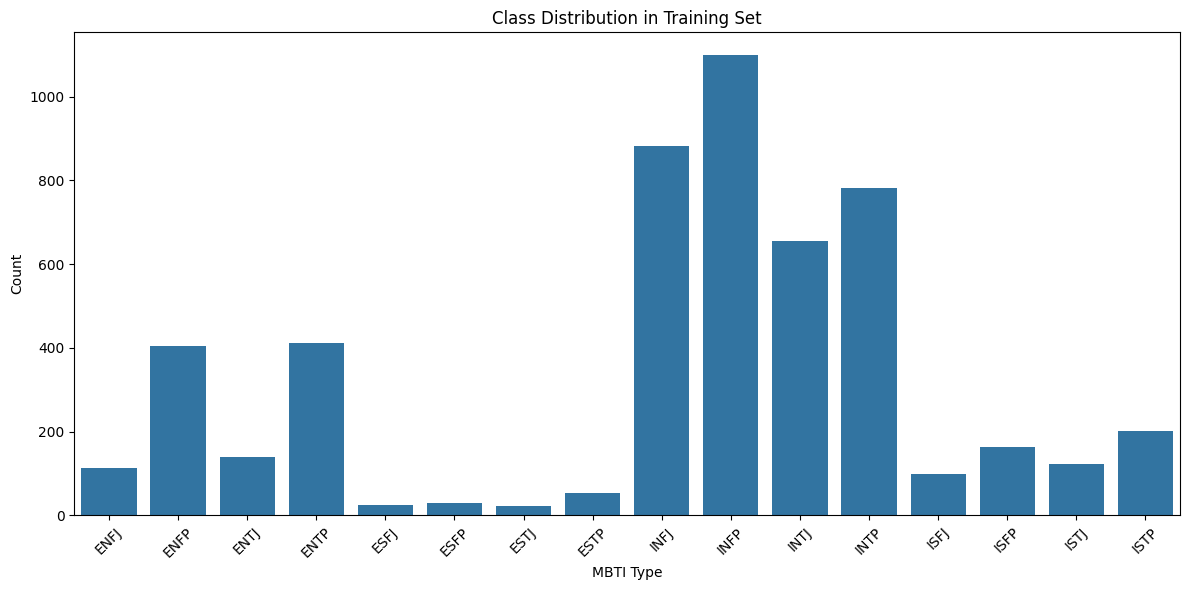


After oversampling:
Training samples: 17584
Class distribution after oversampling:
ENFJ: 1099
ENFP: 1099
ENTJ: 1099
ENTP: 1099
ESFJ: 1099
ESFP: 1099
ESTJ: 1099
ESTP: 1099
INFJ: 1099
INFP: 1099
INTJ: 1099
INTP: 1099
ISFJ: 1099
ISFP: 1099
ISTJ: 1099
ISTP: 1099


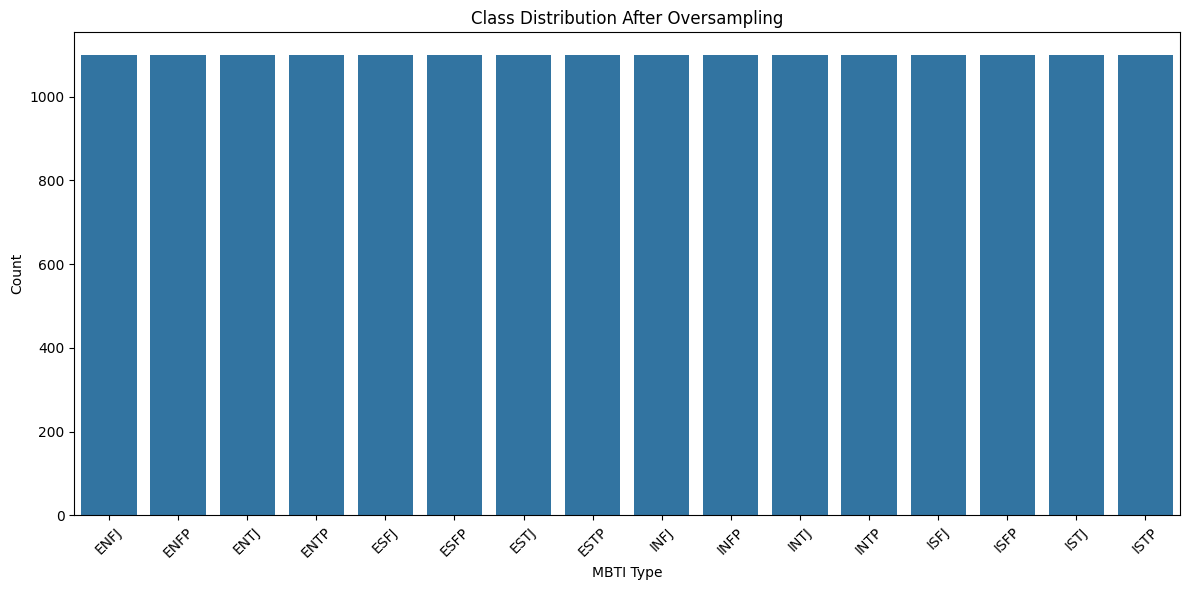

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Get unique classes
classes = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {classes[i]: class_weights[i] for i in range(len(classes))}

print("Class weights to handle imbalance:")
for mbti_type, weight in class_weights_dict.items():
    print(f"{mbti_type}: {weight:.2f}")

# Plot class distribution before handling imbalance
plt.figure(figsize=(12, 6))
class_counts = pd.Series(y_train).value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Training Set')
plt.xlabel('MBTI Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{PROJECT_DIR}/class_distribution_before.png")
plt.show()

# Alternatively, we could oversample the minority classes
# For example, using RandomOverSampler:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Apply oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(
    np.array(X_train).reshape(-1, 1), y_train_encoded)

# Convert back to original format
X_train_resampled = X_train_resampled.flatten()
y_train_resampled = label_encoder.inverse_transform(y_train_resampled)

print(f"\nAfter oversampling:")
print(f"Training samples: {X_train_resampled.shape[0]}")
unique, counts = np.unique(y_train_resampled, return_counts=True)
print("Class distribution after oversampling:")
for i, (class_name, count) in enumerate(zip(unique, counts)):
    print(f"{class_name}: {count}")

# Plot class distribution after oversampling
plt.figure(figsize=(12, 6))
class_counts_after = pd.Series(y_train_resampled).value_counts().sort_index()
sns.barplot(x=class_counts_after.index, y=class_counts_after.values)
plt.title('Class Distribution After Oversampling')
plt.xlabel('MBTI Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{PROJECT_DIR}/class_distribution_after.png")
plt.show()

# Note: If using oversampling, uncomment the lines below to use the resampled data
X_train = X_train_resampled
y_train = y_train_resampled

In [ ]:
import torch
from torch import nn
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

# Define constants
MAX_LEN = 512  # BERT's max sequence length is 512
BATCH_SIZE = 8  # Smaller batch size for GPU memory
LEARNING_RATE = 2e-5
EPOCHS = 4

# Map MBTI types to numerical labels
mbti_types = sorted(df['type'].unique())
label_dict = {mbti_type: i for i, mbti_type in enumerate(mbti_types)}
reverse_label_dict = {i: mbti_type for mbti_type, i in label_dict.items()}

print("MBTI type mapping:")
for mbti_type, idx in label_dict.items():
    print(f"{mbti_type}: {idx}")

# Create a custom dataset
class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = [label_dict[label] for label in labels]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets for training, validation, and test
train_dataset = MBTIDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = MBTIDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = MBTIDataset(X_test, y_test, tokenizer, MAX_LEN)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(mbti_types),
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model loaded and moved to {device}")

MBTI type mapping:
ENFJ: 0
ENFP: 1
ENTJ: 2
ENTP: 3
ESFJ: 4
ESFP: 5
ESTJ: 6
ESTP: 7
INFJ: 8
INFP: 9
INTJ: 10
INTP: 11
ISFJ: 12
ISFP: 13
ISTJ: 14
ISTP: 15


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cuda


In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import time
import random

# Set seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Calculate total training steps
total_steps = len(train_loader) * EPOCHS

# Create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Define loss function with class weights to handle imbalance
class_weights_tensor = torch.tensor([class_weights_dict[reverse_label_dict[i]] for i in range(len(mbti_types))]).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Create a function to calculate accuracy
def calculate_accuracy(preds, labels):
    # Convert predictions to numerical values
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Found checkpoint: /content/drive/MyDrive/mbti_classifier1/mbti_bert_checkpoint_epoch_3.pt
Resuming training from this checkpoint...
Resuming from epoch 3 with validation accuracy 0.6340
Starting training...

Epoch 1/1
Batch 20/2198 - Loss: 0.3730, Accuracy: 0.8750
Batch 40/2198 - Loss: 0.0062, Accuracy: 1.0000
Batch 60/2198 - Loss: 0.0011, Accuracy: 1.0000
Batch 80/2198 - Loss: 0.0020, Accuracy: 1.0000
Batch 100/2198 - Loss: 0.0024, Accuracy: 1.0000
Batch 120/2198 - Loss: 0.0099, Accuracy: 1.0000
Batch 140/2198 - Loss: 0.0657, Accuracy: 1.0000
Batch 160/2198 - Loss: 0.0023, Accuracy: 1.0000
Batch 180/2198 - Loss: 0.1911, Accuracy: 0.8750
Batch 200/2198 - Loss: 0.0240, Accuracy: 1.0000
Batch 220/2198 - Loss: 0.0015, Accuracy: 1.0000
Batch 240/2198 - Loss: 0.0021, Accuracy: 1.0000
Batch 260/2198 - Loss: 0.0082, Accuracy: 1.0000
Batch 280/2198 - Loss: 0.0012, Accuracy: 1.0000
Batch 300/2198 - Loss: 0.0014, Accuracy: 1.0000
Batch 320/2198 - Loss: 0.0015, Accuracy: 1.0000
Batch 340/2198 - L

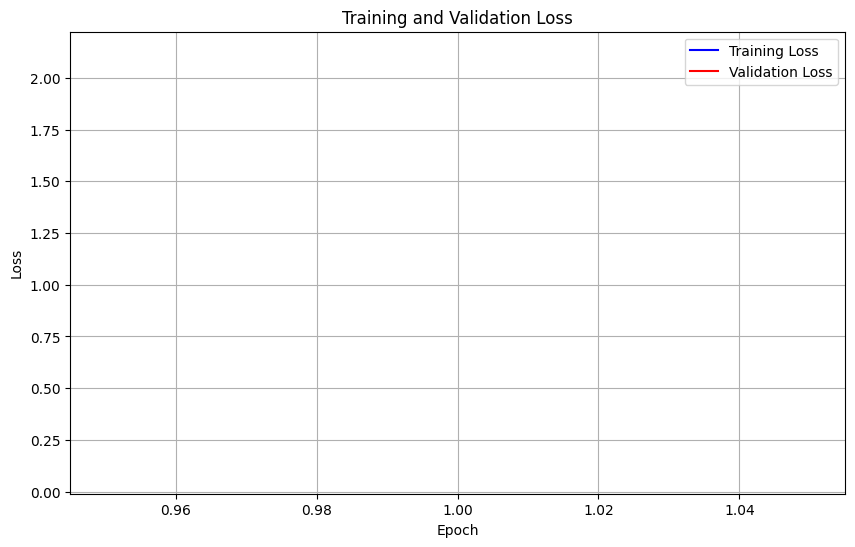

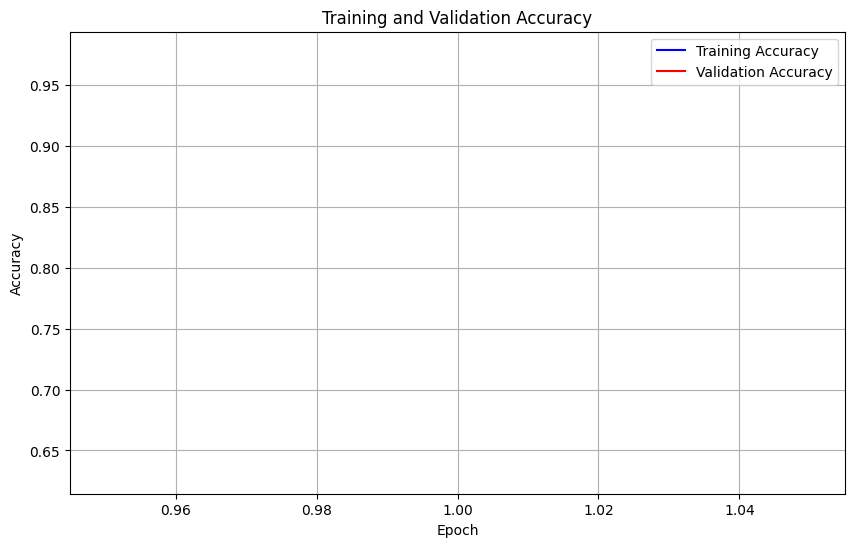

In [ ]:
# Training loop
import glob

def train_model(resume_training):
    # Store training stats
    training_stats = []

    # Track best validation accuracy
    best_accuracy = 0


    # Check if we should resume training
    if resume_training:
        # Find the most recent checkpoint
        checkpoint_files = glob.glob(f"{PROJECT_DIR}/mbti_bert_checkpoint_*.pt")
        if checkpoint_files:
            # Sort by epoch number
            checkpoint_files.sort(key=lambda x: int(re.search(r'epoch_(\d+)', x).group(1)))
            latest_checkpoint = checkpoint_files[-1]

            print(f"Found checkpoint: {latest_checkpoint}")
            print(f"Resuming training from this checkpoint...")

            # Load checkpoint
            checkpoint = torch.load(latest_checkpoint)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch']
            best_accuracy = checkpoint['val_accuracy']

            print(f"Resuming from epoch {start_epoch} with validation accuracy {best_accuracy:.4f}")


    # Store start time for total training time
    total_start_time = time.time()

    print("Starting training...\n")

    for epoch in range(EPOCHS):
        print(f"{'=' * 20}")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"{'=' * 20}")

        # Reset metrics for this epoch
        total_train_loss = 0
        train_correct = 0
        train_total = 0

        # Set model to training mode
        model.train()

        # Store start time for this epoch
        epoch_start_time = time.time()

        # Training loop
        for batch_idx, batch in enumerate(train_loader):
            # Clear gradients
            optimizer.zero_grad()

            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            # Backward pass
            loss.backward()

            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters
            optimizer.step()

            # Update learning rate scheduler
            scheduler.step()

            # Update metrics
            total_train_loss += loss.item()

            # Calculate accuracy for this batch
            preds = logits.detach().cpu().numpy()
            label_ids = labels.detach().cpu().numpy()
            batch_accuracy = calculate_accuracy(preds, label_ids)

            train_correct += (np.argmax(preds, axis=1) == label_ids).sum()
            train_total += len(label_ids)

            # Print progress
            if (batch_idx + 1) % 20 == 0:
                print(f"Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.4f}")

        # Calculate average training loss and accuracy for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        # Validation
        model.eval()

        total_val_loss = 0
        val_preds = []
        val_true_labels = []

        with torch.no_grad():
            for batch in val_loader:
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                logits = outputs.logits

                # Update metrics
                total_val_loss += loss.item()

                # Store predictions and true labels
                val_preds.extend(np.argmax(logits.detach().cpu().numpy(), axis=1))
                val_true_labels.extend(labels.detach().cpu().numpy())

        # Calculate average validation loss and accuracy
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_true_labels, val_preds)
        val_f1 = f1_score(val_true_labels, val_preds, average='weighted')

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time

        print(f"\nEpoch {epoch+1} Results:")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")

        # Store stats for this epoch
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'epoch_time': epoch_time
        })

        # Save model checkpoint if it's the best so far
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            print(f"New best model found! Saving checkpoint...")

            # Save model checkpoint
            checkpoint_path = f"{PROJECT_DIR}/mbti_bert_checkpoint_epoch_{epoch+1}.pt"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_accuracy': val_accuracy,
                'val_f1': val_f1,
                'label_dict': label_dict,
                'reverse_label_dict': reverse_label_dict
            }, checkpoint_path)

    # Calculate total training time
    total_time = time.time() - total_start_time
    print(f"\nTotal training time: {total_time:.2f}s ({total_time/60:.2f} minutes)")

    return training_stats

# Run the training
training_stats = train_model(resume_training=True)

# Plot training and validation loss
epochs = [stat['epoch'] for stat in training_stats]
train_loss = [stat['train_loss'] for stat in training_stats]
val_loss = [stat['val_loss'] for stat in training_stats]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f"{PROJECT_DIR}/loss_plot.png")
plt.show()

# Plot training and validation accuracy
train_acc = [stat['train_accuracy'] for stat in training_stats]
val_acc = [stat['val_accuracy'] for stat in training_stats]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f"{PROJECT_DIR}/accuracy_plot.png")
plt.show()

In [ ]:
# Find the best checkpoint
import glob
import os

checkpoint_files = glob.glob(f"{PROJECT_DIR}/mbti_bert_checkpoint_*.pt")
best_checkpoint = None
best_val_accuracy = 0

for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(checkpoint_file)
    val_accuracy = checkpoint['val_accuracy']

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_checkpoint = checkpoint_file

print(f"Best checkpoint: {os.path.basename(best_checkpoint)} with validation accuracy: {best_val_accuracy:.4f}")

# Save the best model in a format suitable for deployment
best_model_path = f"{PROJECT_DIR}/mbti_bert_best_model.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'label_dict': label_dict,
    'reverse_label_dict': reverse_label_dict,
    'val_accuracy': best_val_accuracy
}, best_model_path)

# Also save the tokenizer for future use
tokenizer_path = f"{PROJECT_DIR}/tokenizer"
tokenizer.save_pretrained(tokenizer_path)

print(f"Best model saved to: {best_model_path}")
print(f"Tokenizer saved to: {tokenizer_path}")

# Save important configuration parameters
import json

config = {
    'model_name': 'bert-base-uncased',
    'max_len': MAX_LEN,
    'label_dict': label_dict,
    'reverse_label_dict': reverse_label_dict,
    'num_labels': len(mbti_types),
    'best_val_accuracy': float(best_val_accuracy)
}

with open(f"{PROJECT_DIR}/model_config.json", 'w') as f:
    json.dump(config, f)

print(f"Model configuration saved to: {PROJECT_DIR}/model_config.json")

Best checkpoint: mbti_bert_checkpoint_epoch_3.pt with validation accuracy: 0.6340
Best model saved to: /content/drive/MyDrive/mbti_classifier1/mbti_bert_best_model.pt
Tokenizer saved to: /content/drive/MyDrive/mbti_classifier1/tokenizer
Model configuration saved to: /content/drive/MyDrive/mbti_classifier1/model_config.json



EVALUATING ON VALIDATION SET

Validation Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.61      0.45      0.52        38
        ENFP       0.62      0.70      0.66       135
        ENTJ       0.77      0.52      0.62        46
        ENTP       0.70      0.51      0.59       137
        ESFJ       0.62      0.62      0.62         8
        ESFP       0.20      0.11      0.14         9
        ESTJ       1.00      0.25      0.40         8
        ESTP       0.67      0.56      0.61        18
        INFJ       0.69      0.58      0.63       294
        INFP       0.60      0.77      0.67       367
        INTJ       0.68      0.67      0.67       218
        INTP       0.61      0.65      0.63       261
        ISFJ       0.52      0.48      0.50        33
        ISFP       0.56      0.57      0.57        54
        ISTJ       0.56      0.61      0.58        41
        ISTP       0.66      0.51      0.58        68

    accuracy   

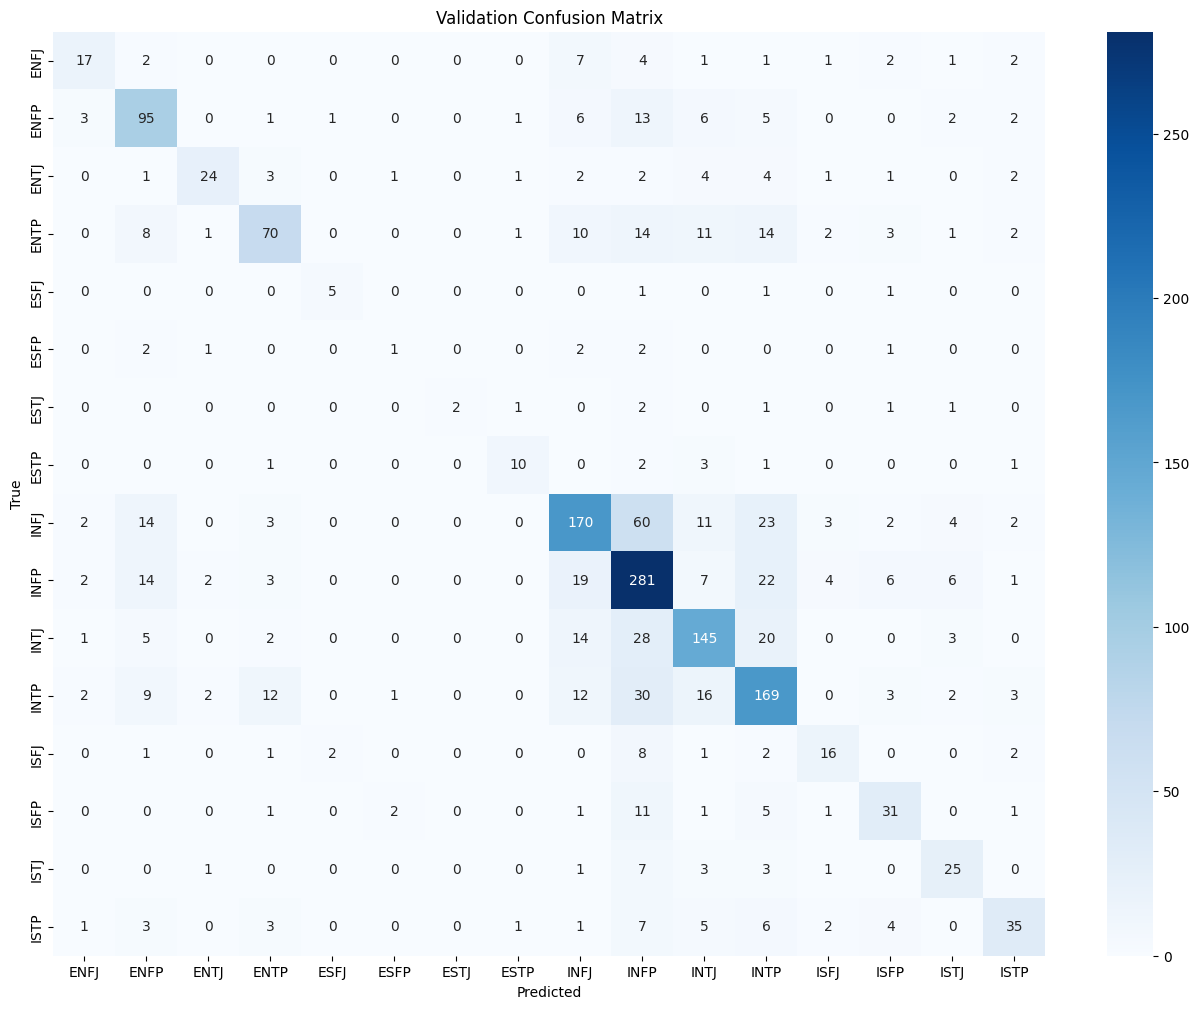


Validation Overall Accuracy: 0.6317
Validation Overall F1 Score: 0.6284

EVALUATING ON TEST SET (HELD-OUT DATA)

Test Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.58      0.68      0.63        38
        ENFP       0.57      0.66      0.61       135
        ENTJ       0.48      0.46      0.47        46
        ENTP       0.60      0.49      0.54       137
        ESFJ       0.27      0.33      0.30         9
        ESFP       0.75      0.30      0.43        10
        ESTJ       0.67      0.25      0.36         8
        ESTP       0.75      0.33      0.46        18
        INFJ       0.71      0.59      0.64       294
        INFP       0.58      0.74      0.65       366
        INTJ       0.65      0.57      0.60       218
        INTP       0.58      0.62      0.60       261
        ISFJ       0.45      0.52      0.48        33
        ISFP       0.58      0.56      0.57        54
        ISTJ       0.52      0.34      0.41    

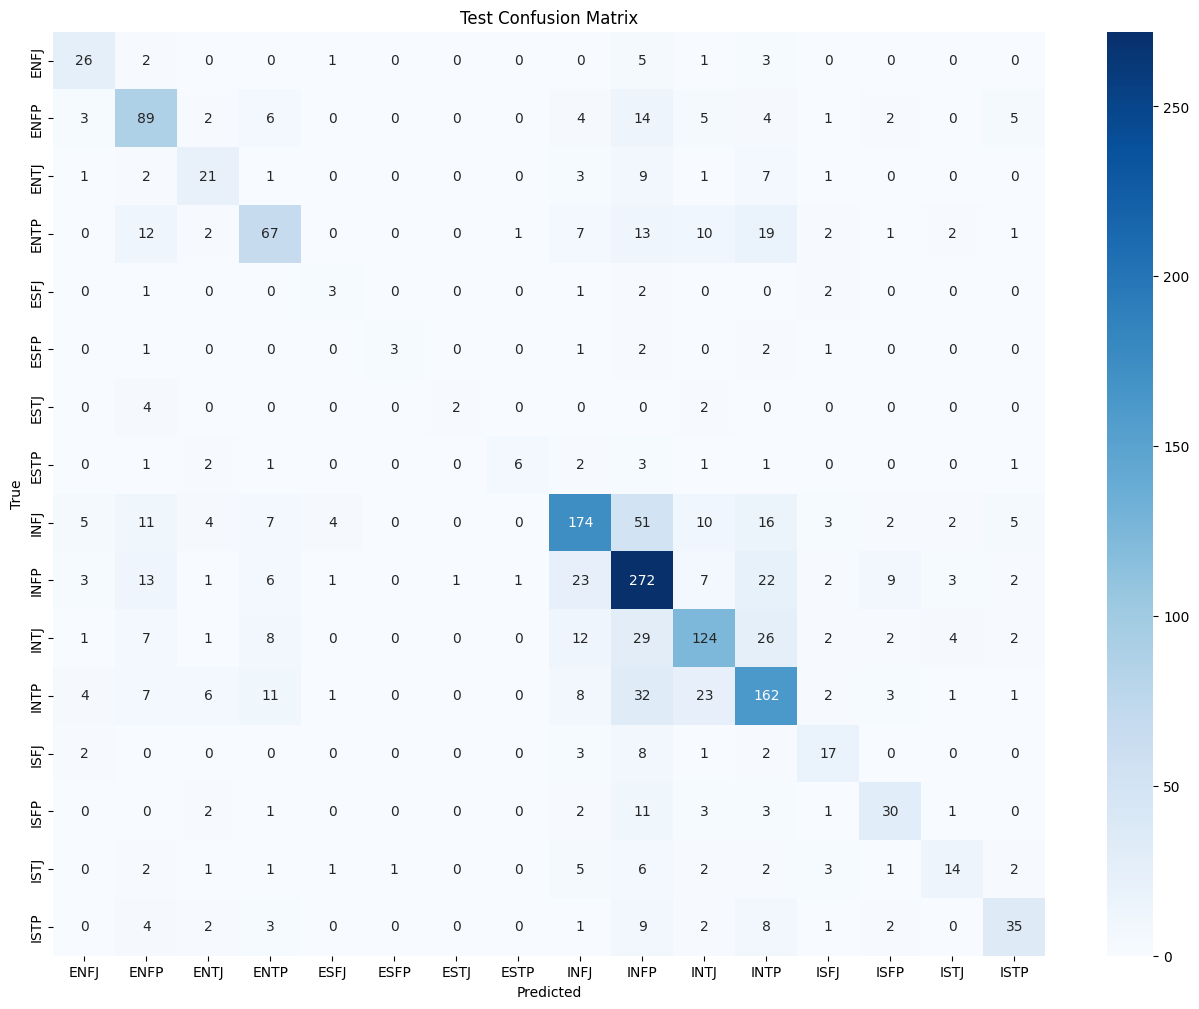


Test Overall Accuracy: 0.6023
Test Overall F1 Score: 0.5992
Evaluation results saved to: /content/drive/MyDrive/mbti_classifier1/evaluation_results.json

RESULTS COMPARISON

Performance Metrics:
          Validation Set  Test Set
Accuracy        0.631700  0.602305
F1 Score        0.628429  0.599200


<Figure size 1000x600 with 0 Axes>

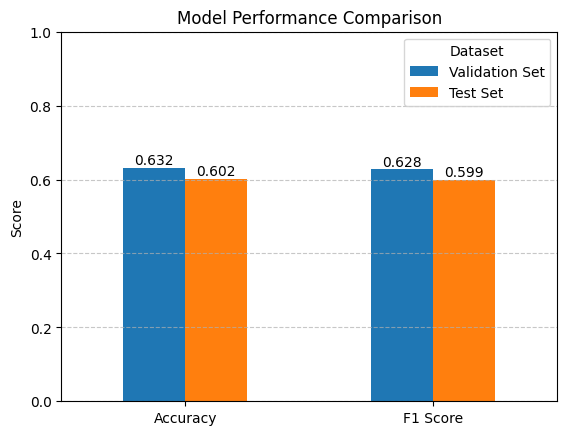

In [ ]:
# Load the best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Function to evaluate model on a dataset
def evaluate_model(data_loader, dataset_name):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            all_preds.extend(predictions)
            all_labels.extend(labels.cpu().numpy())

    # Convert numerical labels back to MBTI types
    all_preds_mbti = [reverse_label_dict[pred] for pred in all_preds]
    all_labels_mbti = [reverse_label_dict[label] for label in all_labels]

    # Generate classification report
    print(f"\n{dataset_name} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=mbti_types))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(16, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mbti_types, yticklabels=mbti_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.savefig(f"{PROJECT_DIR}/{dataset_name.lower()}_confusion_matrix.png")
    plt.show()

    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\n{dataset_name} Overall Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} Overall F1 Score: {f1:.4f}")

    return {
        'accuracy': float(accuracy),
        'f1_score': float(f1),
        'classification_report': classification_report(all_labels, all_preds, target_names=mbti_types, output_dict=True)
    }

# Evaluate on validation set
print("\n" + "="*50)
print("EVALUATING ON VALIDATION SET")
print("="*50)
val_results = evaluate_model(val_loader, "Validation")

# Evaluate on test set (held-out data)
print("\n" + "="*50)
print("EVALUATING ON TEST SET (HELD-OUT DATA)")
print("="*50)
test_results = evaluate_model(test_loader, "Test")

# Save evaluation results
eval_results = {
    'validation': val_results,
    'test': test_results
}

with open(f"{PROJECT_DIR}/evaluation_results.json", 'w') as f:
    json.dump(eval_results, f)

print(f"Evaluation results saved to: {PROJECT_DIR}/evaluation_results.json")

# Create a results comparison table
print("\n" + "="*50)
print("RESULTS COMPARISON")
print("="*50)
comparison_df = pd.DataFrame({
    'Validation Set': [val_results['accuracy'], val_results['f1_score']],
    'Test Set': [test_results['accuracy'], test_results['f1_score']]
}, index=['Accuracy', 'F1 Score'])

print("\nPerformance Metrics:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', rot=0)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.3f')
plt.savefig(f"{PROJECT_DIR}/performance_comparison.png")
plt.show()


==================================================
EVALUATING ON VALIDATION SET
==================================================

Validation Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.61      0.45      0.52        38
        ENFP       0.62      0.70      0.66       135
        ENTJ       0.77      0.52      0.62        46
        ENTP       0.70      0.51      0.59       137
        ESFJ       0.62      0.62      0.62         8
        ESFP       0.20      0.11      0.14         9
        ESTJ       1.00      0.25      0.40         8
        ESTP       0.67      0.56      0.61        18
        INFJ       0.69      0.58      0.63       294
        INFP       0.60      0.77      0.67       367
        INTJ       0.68      0.67      0.67       218
        INTP       0.61      0.65      0.63       261
        ISFJ       0.52      0.48      0.50        33
        ISFP       0.56      0.57      0.57        54
        ISTJ       0.56      0.61      0.58        41
        ISTP       0.66      0.51      0.58        68

    accuracy                           0.63      1735
    macro avg      0.63      0.54      0.56      1735
    weighted avg   0.64      0.63      0.63      1735
    
==================================================

    Validation Overall Accuracy: 0.6317
    Validation Overall F1 Score: 0.6284

==================================================
EVALUATING ON TEST SET (HELD-OUT DATA)
==================================================

Test Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.58      0.68      0.63        38
        ENFP       0.57      0.66      0.61       135
        ENTJ       0.48      0.46      0.47        46
        ENTP       0.60      0.49      0.54       137
        ESFJ       0.27      0.33      0.30         9
        ESFP       0.75      0.30      0.43        10
        ESTJ       0.67      0.25      0.36         8
        ESTP       0.75      0.33      0.46        18
        INFJ       0.71      0.59      0.64       294
        INFP       0.58      0.74      0.65       366
        INTJ       0.65      0.57      0.60       218
        INTP       0.58      0.62      0.60       261
        ISFJ       0.45      0.52      0.48        33
        ISFP       0.58      0.56      0.57        54
        ISTJ       0.52      0.34      0.41        41
        ISTP       0.65      0.52      0.58        67

    accuracy                           0.60      1735
    macro avg      0.59      0.50      0.52      1735
    weighted avg   0.61      0.60      0.60      1735
==================================================

    Test Overall Accuracy: 0.6023
    Test Overall F1 Score: 0.5992
==================================================

Evaluation results saved to: /content/drive/MyDrive/mbti_classifier1/evaluation_results.json

==================================================
RESULTS COMPARISON
==================================================

Performance Metrics:

    Metric          Validation Set  Test Set
    Accuracy        0.631700        0.602305
    F1 Score        0.628429        0.599200

In [ ]:
# Function to preprocess and predict MBTI type for new text
def predict_mbti_type(texts, model, tokenizer, device, max_len=512):
    """
    Predict MBTI type for a list of up to 3 text samples.

    Args:
        texts (list): List of text samples (up to 3)
        model: Trained BERT model
        tokenizer: BERT tokenizer
        device: Device to run inference on
        max_len: Maximum sequence length

    Returns:
        str: Predicted MBTI type
    """
    # Ensure we have at most 3 texts
    texts = texts[:3]

    # Preprocess texts
    processed_texts = [preprocess_text(text) for text in texts]

    # Join texts with [SEP] token
    combined_text = ' [SEP] '.join(processed_texts)

    # Tokenize
    encoding = tokenizer.encode_plus(
        combined_text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Set model to evaluation mode
    model.eval()

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get predicted class
    predicted_class = torch.argmax(logits, dim=1).item()

    # Convert to MBTI type
    predicted_mbti_type = reverse_label_dict[predicted_class]

    # Get probability distribution
    probabilities = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()

    return predicted_mbti_type, {mbti_types[i]: float(probabilities[i]) for i in range(len(mbti_types))}

# Create a simple UI for testing in Colab
from IPython.display import HTML, display
import ipywidgets as widgets

def create_inference_ui():
    text_input1 = widgets.Textarea(
        value='',
        placeholder='Enter your first social media caption or comment',
        description='Text 1:',
        disabled=False,
        layout=widgets.Layout(width='100%', height='80px')
    )

    text_input2 = widgets.Textarea(
        value='',
        placeholder='Enter your second social media caption or comment',
        description='Text 2:',
        disabled=False,
        layout=widgets.Layout(width='100%', height='80px')
    )

    text_input3 = widgets.Textarea(
        value='',
        placeholder='Enter your third social media caption or comment',
        description='Text 3:',
        disabled=False,
        layout=widgets.Layout(width='100%', height='80px')
    )

    output = widgets.Output()

    predict_button = widgets.Button(
        description='Predict MBTI Type',
        disabled=False,
        button_style='primary',
        tooltip='Click to predict'
    )

    def on_button_click(b):
        with output:
            output.clear_output()

            text1 = text_input1.value.strip()
            text2 = text_input2.value.strip()
            text3 = text_input3.value.strip()

            if not text1 and not text2 and not text3:
                print("Please enter at least one text sample.")
                return

            texts = [t for t in [text1, text2, text3] if t]

            print("Predicting MBTI type...")
            predicted_type, probabilities = predict_mbti_type(texts, model, tokenizer, device)

            print(f"\n🎉 Predicted MBTI type: {predicted_type}")

            # Show top 3 most likely types
            print("\nTop 3 most likely types:")
            sorted_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
            for mbti_type, prob in sorted_probs[:3]:
                print(f"{mbti_type}: {prob:.4f} ({prob*100:.2f}%)")

            # Display a bar chart of probabilities
            plt.figure(figsize=(10, 6))
            sorted_types = [t for t, _ in sorted_probs]
            sorted_values = [p for _, p in sorted_probs]
            plt.bar(sorted_types[:5], sorted_values[:5])
            plt.title('Top 5 Most Likely MBTI Types')
            plt.xlabel('MBTI Type')
            plt.ylabel('Probability')
            plt.ylim(0, 1)
            for i, v in enumerate(sorted_values[:5]):
                plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
            plt.show()

    predict_button.on_click(on_button_click)

    display(HTML("<h3>MBTI Type Predictor</h3>"))
    display(HTML("<p>Enter up to 3 social media captions or comments to predict your MBTI personality type:</p>"))
    display(text_input1)
    display(text_input2)
    display(text_input3)
    display(predict_button)
    display(output)

# Run the UI
create_inference_ui()

Textarea(value='', description='Text 1:', layout=Layout(height='80px', width='100%'), placeholder='Enter your …

Textarea(value='', description='Text 2:', layout=Layout(height='80px', width='100%'), placeholder='Enter your …

Textarea(value='', description='Text 3:', layout=Layout(height='80px', width='100%'), placeholder='Enter your …

Button(button_style='primary', description='Predict MBTI Type', style=ButtonStyle(), tooltip='Click to predict…

Output()

In [ ]:
# Save this code as app.py for deployment

from flask import Flask, request, jsonify
from flask_cors import CORS
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import re
import json

app = Flask(__name__)
CORS(app)  # Enable CORS for all routes

# Model paths (update these to your paths)
MODEL_PATH = './mbti_bert_best_model.pt'
TOKENIZER_PATH = './tokenizer'
CONFIG_PATH = './model_config.json'

# Load model configuration
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

MAX_LEN = config['max_len']
label_dict = config['label_dict']
reverse_label_dict = config['reverse_label_dict']

# Convert string keys back to integers for reverse_label_dict
reverse_label_dict = {int(k): v for k, v in reverse_label_dict.items()}

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained(TOKENIZER_PATH)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

# Load the saved model state
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove emojis and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def predict_mbti_type(texts):
    """
    Predict MBTI type for a list of up to 3 text samples.
    """
    # Ensure we have at most 3 texts
    texts = texts[:3]

    # Preprocess texts
    processed_texts = [preprocess_text(text) for text in texts]

    # Join texts with [SEP] token
    combined_text = ' [SEP] '.join(processed_texts)

    # Tokenize
    encoding = tokenizer.encode_plus(
        combined_text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get predicted class
    predicted_class = torch.argmax(logits, dim=1).item()

    # Convert to MBTI type
    predicted_mbti_type = reverse_label_dict[predicted_class]

    # Get probability distribution
    probabilities = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()
    probs_dict = {mbti_type: float(probabilities[i]) for mbti_type, i in label_dict.items()}

    return predicted_mbti_type, probs_dict

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get JSON data from request
        data = request.get_json()

        # Extract texts
        texts = data.get('texts', [])

        # Ensure we have at least one text
        if not texts or len(texts) == 0:
            return jsonify({
                'error': 'Please provide at least one text sample.'
            }), 400

        # Make prediction
        predicted_type, probabilities = predict_mbti_type(texts)

        # Sort probabilities
        sorted_probs = {k: v for k, v in sorted(probabilities.items(), key=lambda item: item[1], reverse=True)}

        # Return prediction
        return jsonify({
            'predicted_type': predicted_type,
            'probabilities': sorted_probs
        })

    except Exception as e:
        return jsonify({
            'error': str(e)
        }), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=False)

FileNotFoundError: [Errno 2] No such file or directory: './model_config.json'